https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full

In [ ]:
#now we will not numpy, we will user tensor
#different data structure
import numpy as np
import tensorflow as tf

#backend of keras
#dataset imported
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import ResNet50

#keras and the layers which are fully connected (Dense), Dropout, Flatten (convert all in vector automatic way), Conv2D and MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Add, SeparableConv2D

#to load a local dataset
import pathlib

In [ ]:
# data_dir = tf.keras.utils.get_file('Machine Learning', origin=data_path, untar = True)
data = "Sized Alzheimer Dataset"
data_dir = pathlib.Path(data)

In [ ]:
from google.colab import drive
import shutil

# Monta Google Drive
drive.mount('/content/drive')

drive_data = "drive/My Drive/MLDA/"
#temp = shutil.copytree(drive_data + data, data)
#for i in range(5):
#    temp = shutil.copytree(drive_data + 'model' + str(i), 'model' + str(i))

def scrivi_e_copia(file_path, contenuto):
    # Scrive nel file in modalità append
    with open(file_path, 'a') as file:
        file.write(contenuto)

    # Copia il file su Google Drive
    try:
        shutil.copy(file_path, drive_data)
        print("File copiato con successo su Google Drive!")
    except Exception as e:
        print("Si è verificato un errore durante la copia del file su Google Drive:")

Mounted at /content/drive


In [ ]:
%%script true
from shutil import rmtree
from os.path import exists

# Specify the path of the directory to be deleted
directory_path = "./" + data

# Check if the directory exists before attempting to delete it
if exists(directory_path):
    rmtree(directory_path)
    print(f"The directory {directory_path} has been deleted.")
else:
    print(f"The directory {directory_path} does not exist.")

The directory ./Sized Alzheimer Dataset does not exist.


In [ ]:
%%script true
!pip3 install py7zr
from py7zr import SevenZipFile

shutil.copy(drive_data + data + ".7z", '.')

with SevenZipFile(data + ".7z", mode='r') as z:
    z.extractall(path=directory_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 51.3 MB/s eta 0:00:00


In [ ]:
# counting the element
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

46322


In [ ]:
# defining the batch size and the dimension of photo
batch_size = 32
img_height = 128
img_width = 128

A **batch** is a set of samples used in one iteration of model training. In machine learning, especially in deep learning, data is often divided into batches to improve computational efficiency. Instead of updating the model's parameters after processing each individual sample, batches allow the model to update its parameters after processing multiple samples at once. This helps to speed up the training process and make better use of computational resources

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 46322 files belonging to 4 classes.
Using 34742 files for training.


In [ ]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 46322 files belonging to 4 classes.
Using 11580 files for validation.


In [ ]:
num_val = int(0.25 * val_test_ds.cardinality().numpy())

# Split validation dataset into two parts: validation and test (5% test and 20% validation -> test 25% of validation)
val_ds = val_test_ds.take(num_val)
test_ds = val_test_ds.skip(num_val)

In [ ]:
class_names = train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Data Augmentation

In [ ]:
rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, "nearest"),
    layers.RandomZoom(0.15, 0.15, "nearest")
])

data_augmentation1 = tf.keras.Sequential([
    layers.RandomRotation(0.2, "nearest")
])

data_augmentation2 = tf.keras.Sequential([
    layers.RandomZoom(0.15, 0.15, "nearest")
])

data_augmentation3 = tf.keras.Sequential([
    layers.RandomTranslation(0.15, 0.15, "nearest")
])

def prepare(image, train = True, mode = 2):
    if mode == 0:
      return data_augmentation(rescale(image), training = train)

    if mode == 1:
      return rescale(image)

    val = np.random.randint(3)
    if val == 0:
      return data_augmentation1(rescale(image), training = train)
    elif val == 1:
      return data_augmentation2(rescale(image), training = train)
    return data_augmentation3(rescale(image), training = train)

In [ ]:
# Original
class CustomNN(Model):
    def __init__(self):
        super(CustomNN, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Original, added another convolutional layer
class CustomNN1(Model):
    def __init__(self):
        super(CustomNN1, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv4 = Conv2D(128, (3, 3), activation='relu', strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Second Paper
class CustomNN2(Model):
    def __init__(self):
        super(CustomNN2, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((4, 4), strides=(2, 2))
        self.conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv4 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.pool4 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Original, removed a convolutional layer
class CustomNN3(Model):
    def __init__(self):
        super(CustomNN3, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Second paper with 8 CVL
class CustomNN4(Model):
    def __init__(self):
        super(CustomNN4, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
        self.conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D((4, 4), strides=(2, 2))
        self.conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv8 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.pool4 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Martin version 1
class CustomNN5(Model):
    def __init__(self):
        super(CustomNN5, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(128, (3, 3), activation='relu', strides=(2, 2))
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        # Adding a global average pooling layer to reduce the dimensions instead of flattening
        self.global_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
# Sam version
class CustomNN6(Model):
    def __init__(self):
        super(CustomNN6, self).__init__()
        self.conv1 = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
        self.pool1 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool4 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.bn = BatchNormalization()
        self.fc1 = Dense(256, activation='leaky_relu')
        self.drop1 = Dropout(0.45) # Drop some nodes during training (prevents overfitting)
        self.fc2 = Dense(8, activation='relu')
        self.drop2 = Dropout(0.4) # Drop some nodes during training (prevents overfitting)
        self.fc3 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Martin version 2
class CustomNN7(Model):
    def __init__(self):
        super(CustomNN7, self).__init__()
        self.conv1 = Conv2D(16, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), strides=(2, 2))
        self.bn3 = BatchNormalization()
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Martin version 3 (Separable Convolutional Layers)
class CustomNN8(Model):
    def __init__(self):
        super(CustomNN8, self).__init__()
        self.conv1 = SeparableConv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = SeparableConv2D(64, (3, 3), padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = SeparableConv2D(128, (3, 3), strides=(2, 2))
        self.bn3 = BatchNormalization()
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Martin version 4 (Global Average Pooling)
class CustomNN9(Model):
    def __init__(self):
        super(CustomNN9, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), padding='same')
        self.conv4 = Conv2D(64, (3, 3), padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.global_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Martin version 5 (Residual Connections)
class CustomNN10(Model):
    def __init__(self):
        super(CustomNN10, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.bn2 = BatchNormalization()
        self.add = Add()
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), padding='same')
        self.bn3 = BatchNormalization()
        self.conv4 = Conv2D(64, (3, 3), padding='same')
        self.bn4 = BatchNormalization()
        #self.add2 = Add()
        self.global_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x_copy = x
        x = self.conv1(x)
        x = self.bn1(x)
        x_copy = self.conv2(x_copy)
        x_copy = self.bn2(x_copy)
        x = self.add([x, x_copy])
        x_copy = x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_copy = self.conv4(x_copy)
        x_copy = self.bn4(x_copy)
        x = self.add([x, x_copy])
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# CustomNN11 (ResNet50)
resnet50 = ResNet50(weights='imagenet',
                    input_shape=(128, 128, 3), # 3 channels because of imagenet
                    include_top=False)

def CustomNN11():
    x = GlobalAveragePooling2D()(resnet50.output)
    output = Dense(4, activation='softmax')(x)

    return Model(inputs=resnet50.input, outputs=output)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.regularizers import l2

# Load the ResNet50 model with pre-trained weights from ImageNet
resnet50 = ResNet50(weights='imagenet',
                    input_shape=(128, 128, 3), # 3 channels because of ImageNet
                    include_top=False)

# Define the custom model with L2 regularization
def CustomNN11bis():
    x = GlobalAveragePooling2D()(resnet50.output)
    output = Dense(4, activation='softmax', kernel_regularizer=l2(1))(x) # L2 regularization

    return Model(inputs=resnet50.input, outputs=output)

In [ ]:
# Majority Vote Model
class CustomNN12(tf.keras.Model):
    def __init__(self, models):
        super(CustomNN12, self).__init__()
        self.models = models

    def call(self, inputs):
        predictions = tf.convert_to_tensor([model(inputs) for model in self.models])
        # Compute the majority vote
        predictions_stack = tf.stack(predictions, axis=0)
        return tf.reduce_mean(predictions_stack, axis=0)

In [ ]:
# Majority Vote Model (re-implemented)
class CustomNN12bis(tf.keras.Model):
    def __init__(self, models):
        super(CustomNN12bis, self).__init__()
        self.models = models

    def call(self, inputs):
        predictions = tf.convert_to_tensor([model(inputs) for model in self.models])

        # Get votes of each model
        votes = np.sum(np.eye(predictions[0].shape[1])[np.argmax(predictions, axis=2)], axis=0)
        '''
        votes = np.zeros_like(predictions[0].numpy())
        for model_vote in predictions:
            indexes = model_vote.argmax(axis=1)
            for row, index in enumerate(indexes):
                votes[row, index] += 1
        '''

        # Normalize the votes
        return tf.convert_to_tensor(votes / votes.sum(axis=1)[:, np.newaxis])

In [ ]:
# Majority Vote Model (re-implemented v2)
class CustomNN12tris(tf.keras.Model):
    def __init__(self, models, accuracies):
        super(CustomNN12tris, self).__init__()
        self.models = models
        self.accuracies = accuracies

    def call(self, inputs):
        predictions = tf.convert_to_tensor([model(inputs) for model in self.models])

        # Get votes of each model (weighted based on the accuracy of the model)
        #votes = np.sum(predictions * self.accuracies, axis=0)
        for index, model_votes in enumerate(predictions):
            model_votes *= self.accuracies[index]
        votes = np.sum(predictions, axis=0)

        # Normalize the votes
        return tf.convert_to_tensor(votes / votes.sum(axis=1)[:, np.newaxis])

**Convolutional Neural Network (CNN):**

A Convolutional Neural Network (CNN) is a type of artificial neural network commonly used for image classification, object detection, and other tasks related to computer vision. CNNs are designed to automatically and adaptively learn spatial hierarchies of features from input images. They consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. CNNs have revolutionized the field of computer vision and are widely used in various applications, including image recognition, medical image analysis, and autonomous driving.

**Fully Connected Layer:**


A fully connected layer, also known as a dense layer, is a type of layer in a neural network where each neuron is connected to every neuron in the previous layer. In a fully connected layer, each neuron receives input from all the neurons in the previous layer and produces an output that is passed to all the neurons in the next layer. Fully connected layers are typically used in the later stages of a neural network to perform classification or regression tasks based on the learned features.

**Dropout:**


Dropout is a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly disables a fraction of neurons in the network, forcing the network to learn redundant representations of the data. This helps to prevent the network from relying too heavily on any one feature, making it more robust and generalizable. Dropout is applied during training but not during inference, where all neurons are used.

**Flatten Layer:**


A flatten layer is a type of layer in a neural network that is used to convert multidimensional input data into a one-dimensional array. This is often necessary when transitioning from convolutional layers, which operate on multidimensional data such as images, to fully connected layers, which require one-dimensional input. The flatten layer reshapes the input data without changing its content, allowing it to be processed by the fully connected layers.

**optimizer**='*adam*':

Adam is an optimization algorithm that is commonly used for training neural networks. It dynamically adjusts the learning rate during training, which can lead to faster convergence and better performance.


**loss**='*sparse_categorical_crossentropy*':

This specifies the loss function used during training. Cross-entropy loss is often used for classification problems. In this case, 'sparse_categorical_crossentropy' is used because the labels are integers (not one-hot encoded). This loss function calculates the difference between the predicted probabilities and the true labels.


**metrics**=['*accuracy*']:

During training, it's useful to monitor certain metrics to evaluate the performance of the model. 'accuracy' is a common metric for classification problems, which measures the proportion of correctly classified examples.

An **epoch** is a complete pass through the entire dataset during the training process. In other words, it represents one cycle of training where the model sees and learns from all the training examples. During each epoch, the model's parameters are adjusted multiple times as it processes batches of data. Training typically involves running multiple epochs to allow the model to learn from the data more effectively.

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
import matplotlib.pyplot as plt

def printPlot(epochs, acc, val_acc, loss, val_loss):
    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Best Models:
- M4: 2, 1
- M2: 3, 3
- M1: 1, 4
- M: 7, 2
- M3: 6, 5
- M5: 4, ...
- M7: 5, ...

In [ ]:
def split_dataset(dataset, num_splits):
    # Conta il numero di campioni nel dataset
    num_samples = dataset.cardinality().numpy()

    if num_samples == tf.data.UNKNOWN_CARDINALITY: # ... = -2
        num_samples = 0
        for _ in dataset:
            num_samples += 1

    assert num_samples > 0, "Error: Not a valid Cardinality!"

    # Calcola il numero di campioni per ciascun split
    samples_per_split = num_samples // num_splits

    # Dividi il dataset in num_splits parti uguali
    dataset_splits = []
    for i in range(num_splits):
        # Seleziona i campioni corrispondenti all'indice
        split_dataset = dataset.skip(i * samples_per_split).take(samples_per_split)
        dataset_splits.append(split_dataset)
    return dataset_splits

In [ ]:
epochs=10

models = [CustomNN(), CustomNN1(), CustomNN2(), CustomNN3(), CustomNN4()]

Nuovo

In [ ]:
def save_hystory(hystory, CustomText):
    # Print Graph Results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    test_results = models[i].evaluate(test_ds)

    # Print Numerical values in the output file
    with open("Results.txt", "a") as txt_file:
        txt_file.write(CustomText + "\n" + str(acc) + " " + str(val_acc) + " " + str(loss) +
                       str(val_loss) + " " + str(test_results[0]) + " " +  str(test_results[1]) + "\n")

In [ ]:
# Augment and combine the datasets
def combine_aug(dataset):
    augmented_ds1 = dataset.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    augmented_ds2 = augmented_ds1.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    augmented_ds3 = dataset.map(lambda x, y: (prepare(x, 0), y), num_parallel_calls=tf.data.AUTOTUNE)
    augmented_ds = tf.data.Dataset.from_tensor_slices([dataset, augmented_ds1, augmented_ds2, augmented_ds3]).flat_map(lambda x: x)
    return augmented_ds.shuffle(buffer_size=100)

train_ds_split = split_dataset(combine_aug(train_ds), len(models))
val_ds_split = split_dataset(val_ds, len(models))

In [ ]:
epochs=10

models = [CustomNN3(), CustomNN4()]

for i in range(len(models)):

    # Compile the Model
    models[i].compile(optimizer="Adam",
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    # Train the Model
    history = models[i].fit(
        train_ds_split[i],
        #aug_train_ds,
        validation_data=val_ds_split[i],
        #validation_data=val_ds,
        epochs=epochs
    )

    save_hystory(history, "- Model " + str(i) + " Mode Split&DupV2")

Epoch 1/10
868/868 [==============================] - 569s 652ms/step - loss: 2.9471 - accuracy: 0.5217 - val_loss: 0.7040 - val_accuracy: 0.6597
Epoch 2/10
868/868 [==============================] - 476s 541ms/step - loss: 0.5761 - accuracy: 0.7561 - val_loss: 0.4514 - val_accuracy: 0.8073
Epoch 3/10
868/868 [==============================] - 453s 521ms/step - loss: 0.3262 - accuracy: 0.8684 - val_loss: 0.4481 - val_accuracy: 0.8420
Epoch 4/10
868/868 [==============================] - 458s 527ms/step - loss: 0.2010 - accuracy: 0.9213 - val_loss: 0.4567 - val_accuracy: 0.8420
Epoch 5/10
868/868 [==============================] - 468s 537ms/step - loss: 0.1394 - accuracy: 0.9489 - val_loss: 0.5524 - val_accuracy: 0.8125
Epoch 6/10
868/868 [==============================] - 474s 545ms/step - loss: 0.1068 - accuracy: 0.9615 - val_loss: 0.6258 - val_accuracy: 0.8264
Epoch 7/10
868/868 [==============================] - 453s 521ms/step - loss: 0.1085 - accuracy: 0.9617 - val_loss: 0.5981 -

<ipython-input-45-f14dda224a29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitle'

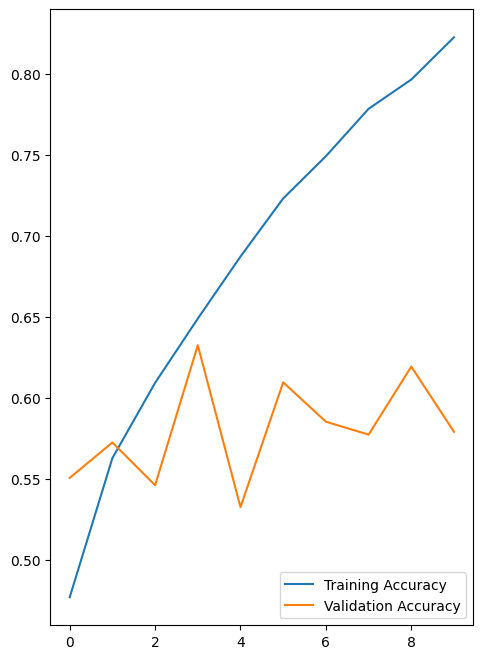

In [ ]:
import matplotlib.pyplot as plt
import zipfile
import ast
import os

def printPlot(epochs, acc, val_acc, loss, val_loss, nome_file):
    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.savefig(nome_file)
    plt.show()

# Funzione per convertire una stringa rappresentante una lista in una lista effettiva
def str_to_list(s):
    return ast.literal_eval(s)

# Leggere il file
with open('Results.txt', 'r') as file:
    lines = file.readlines()

nome_file = "empty.png"

# Creare un file zip per salvare le immagini
with zipfile.ZipFile('grafici.zip', 'w') as zipf:
    # Processare ogni riga
    for i, line in enumerate(lines):

        # Saltare le righe che iniziano con "-"
        if line.startswith('-'):
            nome_file = line[2:] + ".png"
            continue

        parts = line.split('] ')

        # Aggiustare la formattazione delle liste
        parts[0] = parts[0] + ']'
        parts[1] = parts[1] + ']'
        parts[2] = parts[2] + ']'
        parts[3] = parts[3] + ']'

        # Convertire le parti in liste e float
        acc = str_to_list(parts[0])
        val_acc = str_to_list(parts[1])
        loss = str_to_list(parts[2])
        val_loss = str_to_list(parts[3])

        printPlot(epochs, acc, val_acc, loss, val_loss, nome_file)

        zipf.write(nome_file, os.path.basename(nome_file))

In [ ]:
%%script true

#train_ds_split = split_dataset(train_ds, len(models))
#val_ds_split = split_dataset(val_ds, len(models))

aug_train_ds = train_ds.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)
#aug_train_ds = []
#for i in range(len(models)):
#    aug_train_ds.append(train_ds_split[i].map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE))

In [ ]:
#%%script true
# Augment and combine the datasets
def combine_aug(dataset):
    augmented_ds1 = dataset.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    #augmented_ds2 = augmented_ds1.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    #augmented_ds3 = dataset.map(lambda x, y: (prepare(x, 0), y), num_parallel_calls=tf.data.AUTOTUNE)
    augmented_ds = tf.data.Dataset.from_tensor_slices([dataset, augmented_ds1]).flat_map(lambda x: x)
    return augmented_ds.shuffle(buffer_size=100)

aug_train_ds = combine_aug(train_ds)
#train_ds_split = split_dataset(combine_aug(train_ds), len(models))
#val_ds_split = split_dataset(val_ds, len(models))

In [ ]:
%%script true
# Create and compile the model
model50 = CustomNN11bis()

model50.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     #loss='categorical_crossentropy',
                     #loss='kullback_leibler_divergence',
                     metrics=['accuracy'])

# Train the Model
history = model50.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Print Graph Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

test_results = model50.evaluate(test_ds)

# Print Numerical values in the output file
with open("output_ResNet50.txt", "a") as txt_file:
    txt_file.write(str(acc) + " " + str(val_acc) + " " + str(loss) +
        str(val_loss) + " " + str(test_results[0]) + " " +  str(test_results[1]) + "\n")

In [ ]:
for i in range(len(models)):

    # Compile the Model
    models[i].compile(optimizer="Adam",
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    # Train the Model
    history = models[i].fit(
        #train_ds_split[i],
        aug_train_ds,
        #validation_data=val_ds_split[i],
        validation_data=val_ds,
        epochs=epochs
    )

    models[i].save('model' + str(i), save_format="tf")

Epoch 1/10
2172/2172 [==============================] - 79s 34ms/step - loss: 2.5144 - accuracy: 0.4910 - val_loss: 17.0734 - val_accuracy: 0.2764
Epoch 2/10
2172/2172 [==============================] - 74s 34ms/step - loss: 1.0029 - accuracy: 0.5332 - val_loss: 11.7321 - val_accuracy: 0.4462
Epoch 3/10
2172/2172 [==============================] - 73s 33ms/step - loss: 0.9105 - accuracy: 0.5754 - val_loss: 1.6398 - val_accuracy: 0.5785
Epoch 4/10
2172/2172 [==============================] - 72s 33ms/step - loss: 0.7100 - accuracy: 0.6758 - val_loss: 0.8551 - val_accuracy: 0.7434
Epoch 5/10
2172/2172 [==============================] - 72s 32ms/step - loss: 0.6232 - accuracy: 0.7151 - val_loss: 0.6829 - val_accuracy: 0.7983
Epoch 6/10
2172/2172 [==============================] - 73s 33ms/step - loss: 0.5670 - accuracy: 0.7401 - val_loss: 0.8303 - val_accuracy: 0.7882
Epoch 7/10
2172/2172 [==============================] - 72s 33ms/step - loss: 0.5175 - accuracy: 0.7669 - val_loss: 1.1122

In [ ]:
for i in range(5):
    temp = shutil.copytree('model' + str(i), drive_data + 'model' + str(i))

In [ ]:
%%script true
for i in range(5):
    shutil.rmtree('model' + str(i))
    temp = shutil.copytree(drive_data + 'NoSplit/model' + str(i), 'model' + str(i))

In [ ]:
%%script true
for i in range(5):
    models[i] = tf.keras.models.load_model('model' + str(i), compile=True)

In [ ]:
for i in range(len(models)):
    models[i].evaluate(test_ds)

272/272 [==============================] - 65s 235ms/step - loss: 0.5511 - accuracy: 0.8254


In [ ]:
#models[1].predict(test_ds.take(2))

In [ ]:
#models = [models[4], models[2], models[1]]

In [ ]:
MV_modelBis = CustomNN12bis(models)

# You have to do it
MV_modelBis.compile(optimizer="Adam",
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'],
                 run_eagerly=True)

'''
history = MV_modelBis.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=epochs
)
'''

test_results = MV_modelBis.evaluate(test_ds)

with open("Results.txt", "a") as txt_file:
    txt_file.write(str(test_results[0]) + " " +  str(test_results[1]) + "\n")

272/272 [==============================] - 21s 75ms/step - loss: 0.3931 - accuracy: 0.9191


In [ ]:
accuracies = [model.evaluate(val_ds)[1] for model in models]
MV_modelTris = CustomNN12tris(models, accuracies)

# You have to do it
MV_modelTris.compile(optimizer="Adam",
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'],
                 run_eagerly=True)

'''
history = MV_modelTris.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=epochs
)
'''

test_results = MV_modelTris.evaluate(test_ds)

with open("Results.txt", "a") as txt_file:
    txt_file.write(str(test_results[0]) + " " +  str(test_results[1]) + "\n")

272/272 [==============================] - 239s 878ms/step - loss: 0.2508 - accuracy: 0.9264


In [ ]:
print(accuracies)

[0.8065972328186035, 0.9104166626930237, 0.8229166865348816, 0.8232638835906982, 0.8336805701255798]


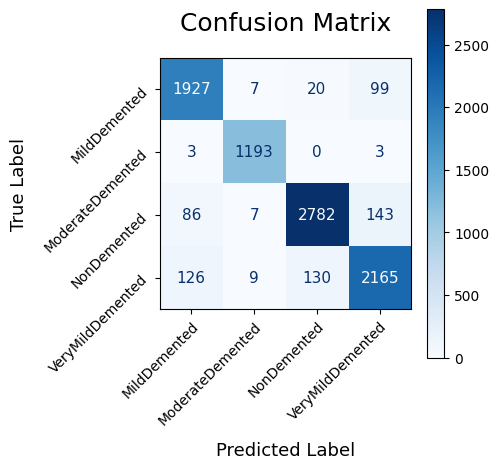

In [ ]:
# dont't execute this part
#%%script true

# Custom class to create a confusion matrix with sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract true labels and predictions
#y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Note: this is necessary (despite being very slow) since predict does not return the predictions in the same order
predictions = []
y_true = []
counter = 1
for batch_images, batch_labels in test_ds:
    print("\r", "Batch " + str(counter) + "/" + str(len(test_ds)), end="")
    counter += 1
    for i in range(batch_size):
        predictions.append(MV_modelTris.predict(np.expand_dims(batch_images[i], axis=0), verbose=0))
        y_true.append(batch_labels[i])

y_true = np.array(y_true)
y_pred = np.argmax(np.concatenate(predictions), axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = class_names)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation = 45, rotation_mode = 'anchor', ha = 'right')  # Rotate x-axis labels
plt.yticks(rotation = 45)  # Rotate y-axis labels
plt.title('Confusion Matrix', fontsize = 18, pad = 20)  # Move title and adjust font size
plt.xlabel('Predicted Label', fontsize = 13, labelpad = 10)  # Increase x-axis label font size and add padding
plt.ylabel('True Label', fontsize = 13, labelpad = 10)  # Increase y-axis label font size and add padding
plt.tick_params(axis='both', which = 'major', labelsize = 10)  # Increase tick label font size

# Adjust text size of the confusion matrix values
for text in disp.text_.ravel():
    text.set_fontsize(11)

plt.gcf().set_size_inches(5, 5)
plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi = 500)  # Save the figure as a PNG file
plt.show()

In [ ]:
shutil.copy("ConfusionMatrix.png", drive_data)

'drive/My Drive/MLDA/ConfusionMatrix.png'